# Sentiment Analysis of Real-time Flipkart Product Reviews

## Import Required Libraries :

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import os
import joblib
import re
import nltk
import pickle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import streamlit as st

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report

nltk.download('stopwords', quiet = True)
nltk.download('wordnet', quiet = True)
nltk.download('omw-1.4', quiet = True)

True

## Load Dataset :

In [5]:
df = pd.read_csv("C:/Users/msnla/Desktop/innomatics/sen_flp/reviews_data_dump/reviews_badminton/data.csv")

In [8]:
# Checking first 5 rows
df.head()

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"Quite O. K. , but nowadays the quality of the...",3
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1


## Exploratory Data Analysis :

In [9]:
print("Dataset Shape:", df.shape)

Dataset Shape: (8518, 8)


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8518 entries, 0 to 8517
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Reviewer Name    8508 non-null   object 
 1   Review Title     8508 non-null   object 
 2   Place of Review  8468 non-null   object 
 3   Up Votes         8508 non-null   float64
 4   Down Votes       8508 non-null   float64
 5   Month            8053 non-null   object 
 6   Review text      8510 non-null   object 
 7   Ratings          8518 non-null   int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 532.5+ KB


In [11]:
df.columns

Index(['Reviewer Name', 'Review Title', 'Place of Review', 'Up Votes',
       'Down Votes', 'Month', 'Review text', 'Ratings'],
      dtype='object')

In [12]:
df.isnull().sum()

Reviewer Name       10
Review Title        10
Place of Review     50
Up Votes            10
Down Votes          10
Month              465
Review text          8
Ratings              0
dtype: int64

In [15]:
df.describe(include='all')

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
count,8508,8508,8468,8508.000000,8508.000000,8053,8510,8518.000000
unique,6243,194,2337,NaN,NaN,80,4983,NaN
top,Flipkart Customer,Wonderful,"Certified Buyer, Bengaluru",NaN,NaN,Oct 2020,GoodREAD MORE,NaN
freq,2098,416,319,NaN,NaN,237,695,NaN
mean,NaN,NaN,NaN,0.391396,0.121768,NaN,NaN,4.181028
std,NaN,NaN,NaN,11.613909,3.248022,NaN,NaN,1.262200
min,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,1.000000
25%,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,4.000000
50%,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,5.000000
75%,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,5.000000


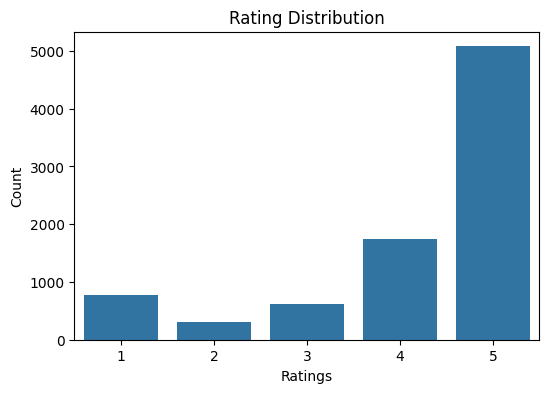

In [18]:
# Checking Rating Distribution
df['Ratings'] = df['Ratings'].astype(int)

plt.figure(figsize=(6,4))
sns.countplot(x='Ratings', data=df, order=sorted(df['Ratings'].unique()))
plt.title("Rating Distribution")
plt.xlabel("Ratings")
plt.ylabel("Count")
plt.show()

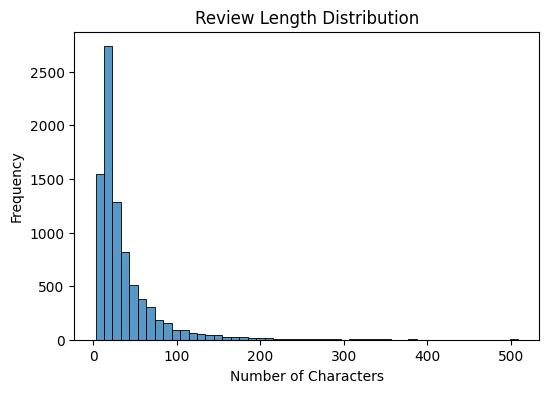

In [21]:
# Checking Review Text Length
df['review_length'] = df['Review text'].astype(str).apply(len)

plt.figure(figsize=(6,4))
sns.histplot(df['review_length'], bins=50)
plt.title("Review Length Distribution")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.show()

In [24]:
df[['Ratings', 'Review text']].sample(5)

,Ratings,Review text
2001,3,Cork is very bad qualityREAD MORE
4488,5,Best in businessREAD MORE
32,2,"After using, found shuttles quality are not up..."
1319,5,SuperREAD MORE
6356,4,goodREAD MORE


In [26]:
df['Ratings'].value_counts().sort_index()

Ratings
1     769
2     308
3     615
4    1746
5    5080
Name: count, dtype: int64

In [31]:
# Creating Sentiment Column

def create_sentiment(rating):
    if rating >= 4:
        return 1   # Positive
    elif rating <= 2:
        return 0   # Negative
    else:
        return np.nan  # Neutral

df['sentiment'] = df['Ratings'].apply(create_sentiment)

df = df.dropna(subset=['sentiment']) # Removes Neutral Reviews

df.loc[:, 'sentiment'] = df['sentiment'].astype(int) # Converts sentiment to integer

df['sentiment'].value_counts() # Verifies class distribution

sentiment
1    6826
0    1077
Name: count, dtype: int64

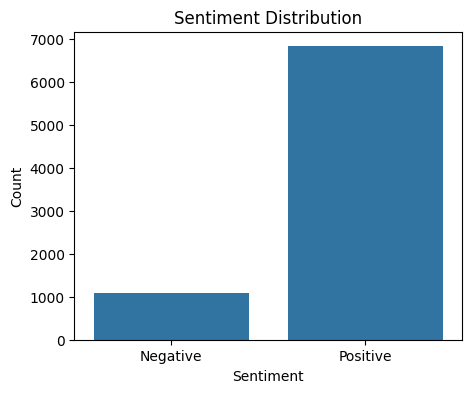

In [32]:
# Visualize sentiment distribution

plt.figure(figsize=(5,4))
sns.countplot(x='sentiment', data=df)
plt.xticks([0,1], ['Negative', 'Positive'])
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

In [33]:
# Sample Labeled Reviews

df[['Ratings', 'Review text', 'sentiment']].sample(5)

,Ratings,Review text,sentiment
4241,5,NiceREAD MORE,1
6103,4,price is reasonable as compare to market but s...,1
5681,5,Very good shuttleREAD MORE,1
7732,4,WorthREAD MORE,1
3935,5,Good oneREAD MORE,1


## Text Preprocessing (Cleaning & Normalization) :

In [71]:
# Initialize Stopwords & Lemmatizer
stop_words = set(stopwords.words('english')) - {"READ MORE", "read more"}
lemmatizer = WordNetLemmatizer()

# Text Cleaning Function
def clean_text(text):
    text = str(text) # Convert to string
    
    text = text.lower() # Lowercase
    
    text = re.sub(r'http\S+|www\S+', '', text) # Remove URLs

    text = re.sub(r'read\s*more', '', text, flags=re.IGNORECASE) # Remove 'read more' phrase
    
    text = re.sub(r'[^a-z\s]', '', text)  # Remove punctuation & special characters
    
    words = text.split() # Tokenize
    
    # Remove stopwords & lemmatize
    words = [lemmatizer.lemmatize(word) 
             for word in words 
             if word not in stop_words]

    return ' '.join(words)  # Join words back

In [72]:
df['clean_review'] = df['Review text'].apply(clean_text)

In [73]:
df[['Review text', 'clean_review']].sample(5)

,Review text,clean_review
4086,Good enough to playREAD MORE,good enough play
7714,AwesomeREAD MORE,awesome
3365,NiceREAD MORE,nice
236,Quality is not good. Little bit fast.READ MORE,quality good little bit fast
1409,niceREAD MORE,nice


In [74]:
df['clean_review'].str.len().describe()

count    7903.000000
mean       21.338353
std        27.241961
min         0.000000
25%         5.000000
50%        12.000000
75%        26.000000
max       349.000000
Name: clean_review, dtype: float64

In [75]:
df = df[df['clean_review'].str.strip() != '']

In [76]:
df[['clean_review', 'sentiment']].head()

,clean_review,sentiment
0,nice product good quality price rising bad sig...,1
1,didnt supplied yonex mavis outside cover yonex...,0
2,worst product damaged shuttlecock packed new b...,0
4,pricedjust retaileri didnt understand wat adva...,0
5,good quality product delivered time,1


## Train–Test Split :

In [83]:
X = df['clean_review']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Initializing TF-IDF Vectorizer :

In [86]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("Train shape:", X_train_tfidf.shape)
print("Test shape:", X_test_tfidf.shape)


Train shape: (6319, 5000)
Test shape: (1580, 5000)


In [87]:
tfidf.get_feature_names_out()[:20]

array(['aa gya', 'aajao', 'aajao yaha', 'aapke', 'aapke yaha', 'able',
       'able authenticate', 'aboutdelieveryflipkart',
       'aboutdelieveryflipkart deleiver', 'absence', 'absence mavis',
       'absolute', 'absolute treasure', 'absolutely', 'absolutely amazed',
       'absolutely original', 'acceptable', 'according', 'accuracy',
       'actual'], dtype=object)

## Machine Learning Models :

In [93]:
# Dictionary to store models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Linear SVM": LinearSVC(),
    "Random Forest": RandomForestClassifier(n_estimators=200)}

results = []

# Train, predict, evaluate
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    
    f1 = f1_score(y_test, y_pred)
    
    results.append({
        "Model": model_name,
        "F1 Score": f1
    })
    
    print(f"{model_name} F1 Score: {f1:.4f}")
    print(classification_report(y_test, y_pred))

# Convert results to DataFrame
results_df = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False)

print("\nModel Comparison:")
results_df


Training Logistic Regression...
Logistic Regression F1 Score: 0.9530
              precision    recall  f1-score   support

           0       0.81      0.51      0.62       215
           1       0.93      0.98      0.95      1365

    accuracy                           0.92      1580
   macro avg       0.87      0.74      0.79      1580
weighted avg       0.91      0.92      0.91      1580


Training Naive Bayes...
Naive Bayes F1 Score: 0.9519
              precision    recall  f1-score   support

           0       0.90      0.41      0.56       215
           1       0.91      0.99      0.95      1365

    accuracy                           0.91      1580
   macro avg       0.91      0.70      0.76      1580
weighted avg       0.91      0.91      0.90      1580


Training Linear SVM...
Linear SVM F1 Score: 0.9549
              precision    recall  f1-score   support

           0       0.76      0.61      0.68       215
           1       0.94      0.97      0.95      1365

    ac

,Model,F1 Score
3,Random Forest,0.955245
2,Linear SVM,0.954890
0,Logistic Regression,0.953025
1,Naive Bayes,0.951879


## Final Model Selection :

In [115]:
# Best Model
best_model_name = results_df.iloc[0]['Model']
print("Best Model:", best_model_name)

# Classification Report
print(f"{best_model_name} F1 Score: {f1:.4f}")
print(classification_report(y_test, y_pred))

print(f"{best_model_name} is selected as final model")

Best Model: Random Forest
Random Forest F1 Score: 0.9552
              precision    recall  f1-score   support

           0       0.80      0.56      0.66       215
           1       0.93      0.98      0.96      1365

    accuracy                           0.92      1580
   macro avg       0.87      0.77      0.81      1580
weighted avg       0.92      0.92      0.91      1580

Random Forest is selected as final model


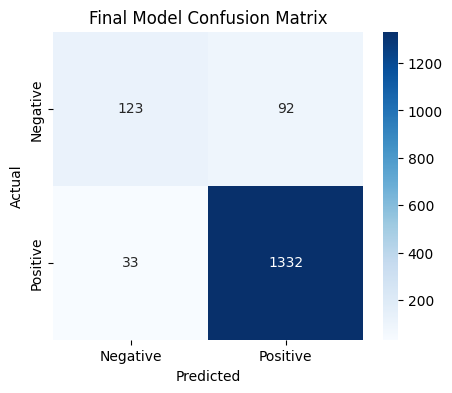

In [120]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Negative', 'Positive'],
    yticklabels=['Negative', 'Positive']
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Final Model Confusion Matrix")
plt.show()

## Save Model & TF-IDF Vectorizer :

In [137]:
joblib.dump(best_model, "models/best_sentiment_model.joblib")
joblib.dump(tfidf, "models/tfidf_vectorizer.joblib")

print("Model and Vectorizer saved successfully")

Model and Vectorizer saved successfully
